In [31]:
#IMPORTS
import numpy as np
from Crypto.Cipher import AES
from Crypto.Hash import MD5
from Crypto.Util.Padding import pad, unpad
from Crypto.Util.number import long_to_bytes
from sage.all import *

Veillez à utiliser un kernel Sagemath et non python !

# CSIDH

https://csidh.isogeny.org/csidh-20181118.pdf

*A la différence de l'implémentation classique de CSIDH, nous n'utiliserons que des coefficients positifs dans la clef privée (cela simplifie l'implémentation temps constant et les concepts mathématiques utilisés)*

## Construction de $p\in\mathcal{P}$
* On choisit n petits nombres premiers $l_1,...,l_n$
* On vérifie que $p=4.l_1....l_n-1$ est premier
* On s'intéresse aux $l_i$-isogénies entre les éléments de X

In [32]:
li=[3,5,7]
p=4*np.product(li)-1
assert(is_prime(p))
K=GF(p) #K est maintenant assimilé à Fp ou Z/pZ

## Ensemble de courbes elliptiques
* On se place sur l'ensemble $X=\{\text{Courbes elliptiques supersingulières sur }\mathbb{F}_p\text{ de la forme } y²=x³+Ax²+x \}$

In [33]:
E0=EllipticCurve(K,[0,0,0,1,0])
E0

Elliptic Curve defined by y^2 = x^3 + x over Finite Field of size 419

In [34]:
#Renvoi la courbe elliptique E : y²=x³+Ax²+x
def curve_from_A(A):
    try:
        E=EllipticCurve(K,[0,A,0,1,0])
    except:
        return False
    return E

## Calculs d'isogénies

* Une isogénie est un morphisme non nul décrit par des fonctions rationnelles entre deux courbes elliptiques E et E'

$$ \varphi \text{ : } E \to E'$$

$$(x,y)\mapsto (R(x,y),R(x,y))$$

* On s'intéresse aux $l_i$-isogénies entre les éléments de X c'est à dire aux isogénies de degré li
* Le degré d'une isogénie est la taille de son noyau (dans notre cas)

### Graphe d'isogénie

* Les sommets sont des courbes elliptiques de X
* Les arêtes sont les $l_i$-isogénies

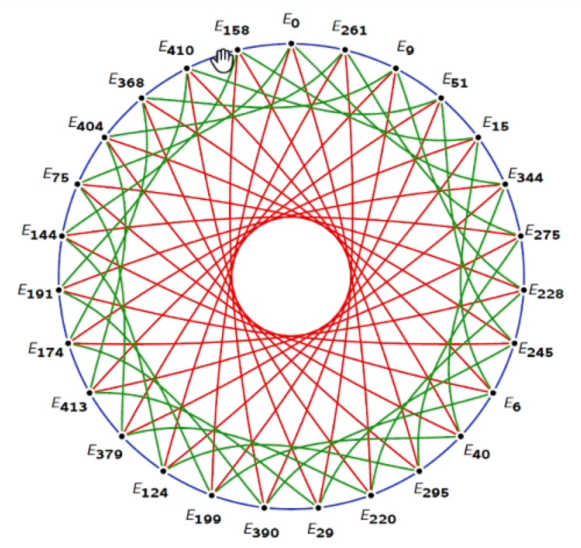

### Formules de Vélu

Donne les étapes pour passer d'une courbe E à une courbe E' avec une isogénie de degré $l$ :

* On trouve P un point d'ordre $l$ sur la courbe E et on note  $\forall i\in[|1,l[|$,   $x_i$ la coordonnée en x de $iP$
* On calcule :
$$\tau = \prod^{l-1}_{i=1} x_i \text{, } \quad \sigma= \sum_{i=1}^{l-1}\left(x_i-\dfrac{1}{x_i}\right)\text{, } \quad f(x)=x\prod_{i=1}^{l-1}\dfrac{xx_i-1}{x-x_i}$$
* On obtient alors la $l$-isogénie de noyau $\langle P \rangle$ :

$$\varphi_l \text{: } E_A \to E_B$$

$$(x,y)\mapsto (f(x), c_0yf'(x))$$

Où $B=\tau(A-3\sigma)$ et $c_0²=\tau$

La courbe d'arrivée de dépend que de l'ordre $l$ !

In [35]:
def Velu(A,E): # E une courbe elliptique et A un point de E d'ordre l
    # Calcul des xi
    X = []
    for i in range(1, A.order()):
        X.append((i*A)[0])

    X=np.array(X)
    # Calcul de tau
    tau = np.product(X)

    # Calcul de sigma
    sigma = np.sum(X - 1//X)

    # Calcul de B, l'indice de la courbe d'arrivée
    B = tau * (E.a_invariants()[1] - 3 * sigma)

    return curve_from_A(B)

In [36]:
assert(Velu(E0(178,367), E0)==curve_from_A(158))

### Evaluer l'action de groupe

On veut maintenant évaluer un chemin entier d'isogénies comme proposé dans la description de CSIDH : 

(pour rappel on utilise uniquement des coefficients positifs pour le chemin d'isogénies)

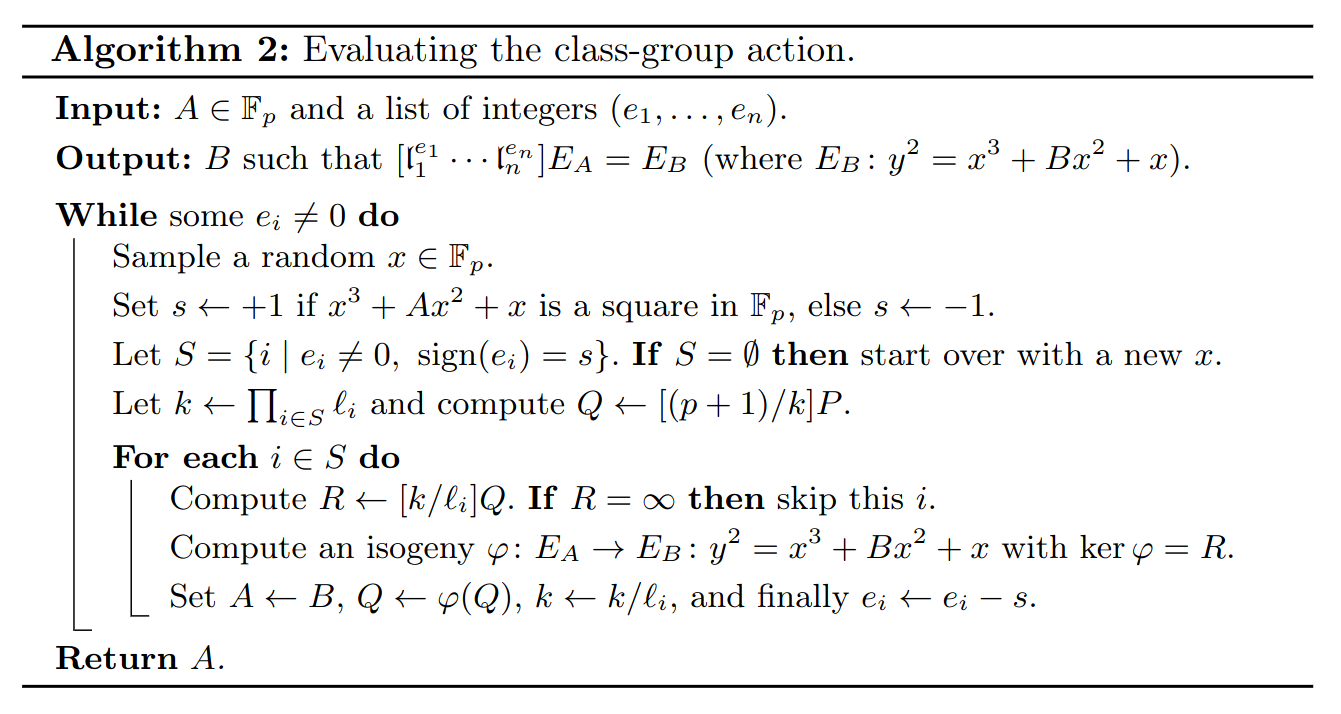

In [37]:
# Renvoi la courbe d'arrivée en partant de la courbe elliptique EA et en suivant le "chemin d'isogénies" représenté par C
def evaluate_class_group_action_positive(A,Chemin): #avec A le coefficient de la courbe de départ et Chemin=[e1,e2,...,en] le chemin représenté par la classe d'idéaux
    C=Chemin.copy()
    lis=[3,5,7]
    curve=curve_from_A(A)
    assert(curve.is_supersingular())
    while C.any(): 
        x=K.random_element()
        try :
            P=curve.lift_x(x)
        except: # Il n'y a pas de point de coordonnée x sur la courbe elliptique
            _ # Pas important pour nous puisque l'on ne prend que des chemins positifs
        else: # P est un des point de coordonnée x sur la courbe elliptique
            s = 1 if is_square(x**3+A*x**2+x) is not None else -1
            S = [i for i in range(len(C)) if C[i] != 0 and sign(C[i]) == s]
            if len(S) == 0:
                continue
            for i in S:
                try:
                    R = curve(*((p+1)//lis[i] * P))
                    if R.order() != lis[i]:
                        continue
                except:
                    continue
                curve = Velu(R, curve)
                C[i] = C[i] - s
    
    return curve                              
                    

In [38]:
curve=evaluate_class_group_action_positive(0,np.array([4,1,1]))
assert(curve==curve_from_A(275))

In [39]:
Private_key=np.array([6,7,8])
Public_key=evaluate_class_group_action_positive(0, Private_key).a2()

In [40]:
# Reçu d'Alice : 
Alice_public_key=245

In [41]:
Shared_secret=evaluate_class_group_action_positive(Alice_public_key, Private_key).a2()

In [42]:
# La clef est composée des 16 premiers bytes du MD5 du Shared_secret
hash = MD5.new(long_to_bytes(int(Shared_secret)))
key=hash.digest()[:16]

In [43]:
def decrypt_message(encrypted_message, key):
    cipher = AES.new(key, AES.MODE_ECB)
    decrypted_message = cipher.decrypt(encrypted_message)
    unpadded_message = unpad(decrypted_message, AES.block_size)
    return unpadded_message.decode()

In [44]:
chiffré = b'\xe67\x98\xc7\xccU5\xf5\xd2\xfd\xd4\x88\x9d\x16\x98r<\x92\xb6\xc0\x1f\xf9\x04\xf8xj\x1f\xa5e\xbe&\x8b\xbd\x04\xe8\xb8m\x92\x98\xbf\xcd\xa5\xaa~\x93\xa8^\xee_\x8a\xd0O\xce\xeb\x83\xdc\xf6\xbb\xd3\xb6\x0c5\x88)\x0c\xa6l[\ni;{\xe9\xe4\xe9\xf7G)c\x08'

In [45]:
decrypt_message(chiffré,key)

"Personne ne pourra nous écouter ! 404CTF{C4lcul_d'1s0g3n135_3n_b0rd_d3_m3r}"

Bonne chance pour les vrai challenges sur CSIDH qui suivent celui-ci !

Si vous avez des questions envoyez les moi **@phengar** sur le discord :)

Images des graphes d'isogénie par Tanja Lange : https://www.youtube.com/@tanjalangepost-quantumcryp2802
Image de l'algorithme d'évalutation de l'action de groupe : https://csidh.isogeny.org/csidh-20181118.pdf